In [2]:
%pip install pandas numpy scikit-learn xgboost matplotlib joblib



  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)


In [3]:
import os, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib

In [8]:
DATA = Path("../data/raw/Metro_Interstate_Traffic_Volume.csv")
MODELS = Path("models"); MODELS.mkdir(parents=True, exist_ok=True)
OUTPUTS = Path("outputs"); OUTPUTS.mkdir(parents=True, exist_ok=True)

plt.rcParams["figure.figsize"] = (10, 3)
plt.rcParams["axes.grid"] = True


In [9]:
df = pd.read_csv(DATA)
# parse datetime (day-first as in your file: 02-10-2012 09:00)
df["date_time"] = pd.to_datetime(df["date_time"], format="%d-%m-%Y %H:%M", errors="coerce")
df = df.dropna(subset=["date_time"]).sort_values("date_time").reset_index(drop=True)

df.head(), df.shape


(   traffic_volume holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
 0            5545     NaN  288.28      0.0      0.0          40       Clouds   
 1            4516     NaN  289.36      0.0      0.0          75       Clouds   
 2            4767     NaN  289.58      0.0      0.0          90       Clouds   
 3            5026     NaN  290.13      0.0      0.0          90       Clouds   
 4            4918     NaN  291.14      0.0      0.0          75       Clouds   
 
   weather_description           date_time  
 0    scattered clouds 2012-10-02 09:00:00  
 1       broken clouds 2012-10-02 10:00:00  
 2     overcast clouds 2012-10-02 11:00:00  
 3     overcast clouds 2012-10-02 12:00:00  
 4       broken clouds 2012-10-02 13:00:00  ,
 (48204, 9))

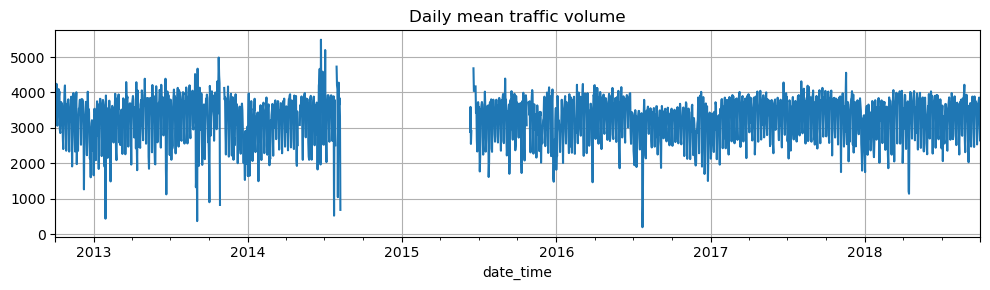

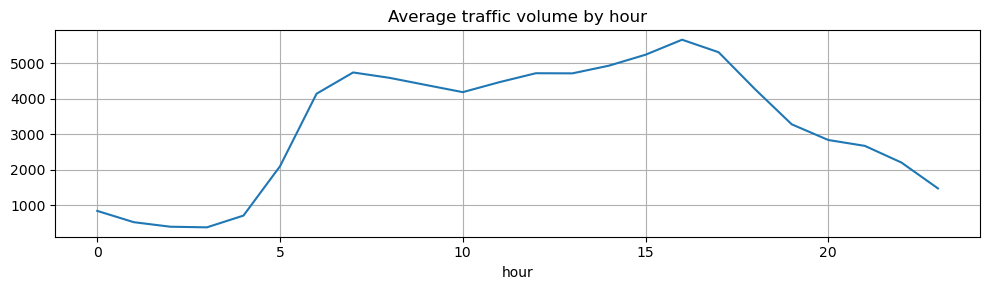

In [10]:
# daily mean
df.set_index("date_time")["traffic_volume"].resample("D").mean().plot()
plt.title("Daily mean traffic volume"); plt.tight_layout(); plt.show()

# avg by hour
df["hour"] = df["date_time"].dt.hour
df.groupby("hour")["traffic_volume"].mean().plot()
plt.title("Average traffic volume by hour"); plt.tight_layout(); plt.show()


In [11]:
def make_time_weather_features(frame: pd.DataFrame) -> pd.DataFrame:
    f = frame.copy()
    if "date_time" in f.columns:
        f["hour"] = f["date_time"].dt.hour
        f["dayofweek"] = f["date_time"].dt.dayofweek
        f["month"] = f["date_time"].dt.month
    f = pd.get_dummies(
        f,
        columns=["holiday", "weather_main", "weather_description"],
        drop_first=True
    )
    return f


In [12]:
now_df = make_time_weather_features(df)

target_now = "traffic_volume"
X_now = now_df.drop(columns=[target_now, "date_time"])
y_now = now_df[target_now]

# time-ordered split
split_idx = int(len(now_df) * 0.8)
Xtr_now, Xte_now = X_now.iloc[:split_idx], X_now.iloc[split_idx:]
ytr_now, yte_now = y_now.iloc[:split_idx], y_now.iloc[split_idx:]

model_now = XGBRegressor(
    n_estimators=300, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1
)
model_now.fit(Xtr_now, ytr_now)

pred_now = model_now.predict(Xte_now)
mae_now = mean_absolute_error(yte_now, pred_now)
rmse_now = math.sqrt(mean_squared_error(yte_now, pred_now))

mae_now, rmse_now


(292.2127886289829, 503.98613695859666)

C:\Users\ilham\AppData\Local\Temp\ipykernel_36900\3202304141.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


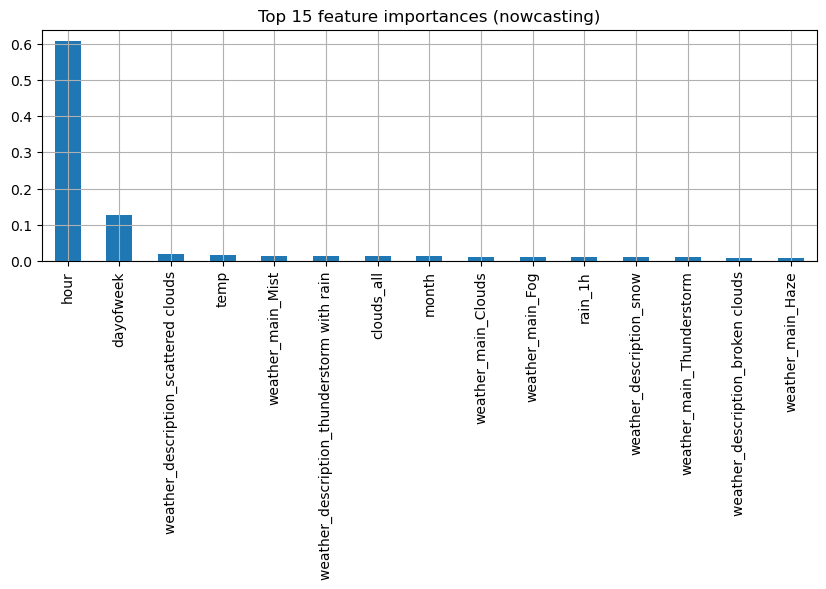

In [13]:
imp = pd.Series(model_now.feature_importances_, index=Xtr_now.columns).sort_values(ascending=False).head(15)
ax = imp.plot(kind="bar")
ax.set_title("Top 15 feature importances (nowcasting)")
plt.tight_layout(); plt.show()


In [14]:
art_now = {
    "model": model_now,
    "columns": Xtr_now.columns.tolist(),
    "metrics": {"mae": float(mae_now), "rmse": float(rmse_now)},
    "task": "nowcasting"
}
joblib.dump(art_now, MODELS / "model_xgb.joblib")

pd.DataFrame(
    {"metric": ["MAE","RMSE"], "value":[mae_now, rmse_now]}
).to_csv(OUTPUTS / "metrics_nowcasting.csv", index=False)

pd.DataFrame({
    "timestamp": df["date_time"].iloc[split_idx:].values,
    "actual": yte_now.values,
    "pred": pred_now
}).head(500).to_csv(OUTPUTS / "sample_predictions_nowcasting.csv", index=False)

MODELS / "model_xgb.joblib", OUTPUTS / "metrics_nowcasting.csv"


(WindowsPath('models/model_xgb.joblib'),
 WindowsPath('outputs/metrics_nowcasting.csv'))

In [15]:
lag_df = df.copy()
for h in [1, 2, 3, 4]:
    lag_df[f"lag_{h}h"] = lag_df["traffic_volume"].shift(h)

# target = next hour
lag_df["y_next_hour"] = lag_df["traffic_volume"].shift(-1)

lag_df = lag_df.dropna().reset_index(drop=True)

# add time + weather one-hots
lag_df = make_time_weather_features(lag_df)

target_fx = "y_next_hour"
drop_cols = [c for c in ["traffic_volume","date_time"] if c in lag_df.columns]
X_fx = lag_df.drop(columns=drop_cols + [target_fx])
y_fx = lag_df[target_fx]

split_idx_fx = int(len(lag_df) * 0.8)
Xtr_fx, Xte_fx = X_fx.iloc[:split_idx_fx], X_fx.iloc[split_idx_fx:]
ytr_fx, yte_fx = y_fx.iloc[:split_idx_fx], y_fx.iloc[split_idx_fx:]

model_fx = XGBRegressor(
    n_estimators=500, max_depth=6, learning_rate=0.08,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, n_jobs=-1
)
model_fx.fit(Xtr_fx, ytr_fx)

pred_fx = model_fx.predict(Xte_fx)
mae_fx = mean_absolute_error(yte_fx, pred_fx)
rmse_fx = math.sqrt(mean_squared_error(yte_fx, pred_fx))

mae_fx, rmse_fx


(93.41879507211539, 127.55827699311425)

In [16]:
art_fx = {
    "model": model_fx,
    "columns": Xtr_fx.columns.tolist(),
    "metrics": {"mae": float(mae_fx), "rmse": float(rmse_fx)},
    "task": "next_hour_forecast"
}
joblib.dump(art_fx, MODELS / "model_xgb_t+60.joblib")

pd.DataFrame(
    {"metric": ["MAE","RMSE"], "value":[mae_fx, rmse_fx]}
).to_csv(OUTPUTS / "metrics_forecast_t+60.csv", index=False)

pd.DataFrame({
    "timestamp": lag_df["date_time"].iloc[split_idx_fx:].values,
    "actual_next_hour": yte_fx.values,
    "pred_next_hour": pred_fx
}).head(500).to_csv(OUTPUTS / "sample_predictions_t+60.csv", index=False)

MODELS / "model_xgb_t+60.joblib", OUTPUTS / "metrics_forecast_t+60.csv"


(WindowsPath('models/model_xgb_t+60.joblib'),
 WindowsPath('outputs/metrics_forecast_t+60.csv'))

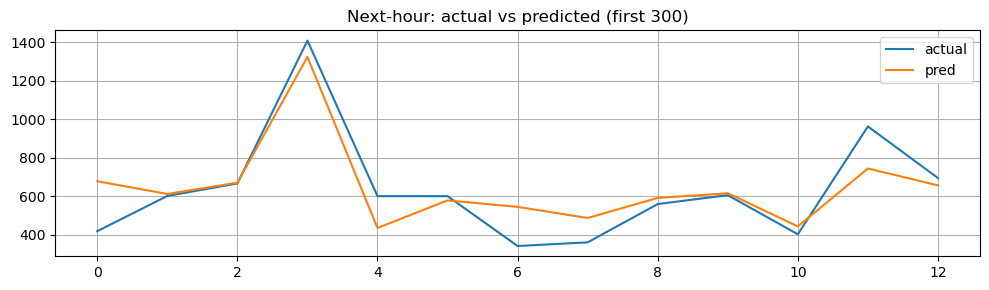

In [17]:
pd.DataFrame({"actual": yte_fx.values[:300], "pred": pred_fx[:300]}).plot()
plt.title("Next-hour: actual vs predicted (first 300)")
plt.tight_layout(); plt.show()


In [18]:
print("NOWCAST  → MAE: %.1f | RMSE: %.1f" % (mae_now, rmse_now))
print("T+60     → MAE: %.1f | RMSE: %.1f" % (mae_fx, rmse_fx))


NOWCAST  → MAE: 292.2 | RMSE: 504.0
T+60     → MAE: 93.4 | RMSE: 127.6
